Y_data: 20640
y_data: 19648
y_data: 18665
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  28.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  28.3s
[CV] END max_depth=None, max_features=No

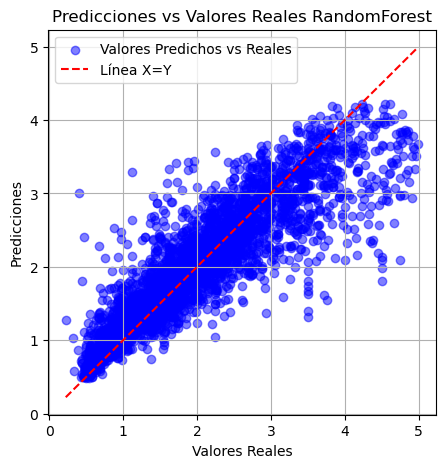


Epsilon = 1e-07
Error del ruido:
MSE: 2801636487298545.5
MAE: 13262357.771475486
RMSE: 52930487.31400973
R2: -1163243326766233.2

Predicción de precios con ruido:
MSE: 0.20534014318762472
MAE: 0.3062427456558621
RMSE: 0.45314472653626314
R2: 0.7839244707358493

Epsilon = 0.0001
Error del ruido:
MSE: 2770597944.676884
MAE: 13228.620088574376
RMSE: 52636.46972087779
R2: -1150356080.1364448

Predicción de precios con ruido:
MSE: 0.2073753460644134
MAE: 0.3088856405214751
RMSE: 0.45538483293189885
R2: 0.7817828654367811

Epsilon = 0.1
Error del ruido:
MSE: 2813.9477344119086
MAE: 13.271307016751697
RMSE: 53.0466562038731
R2: -1167.3549735175936

Predicción de precios con ruido:
MSE: 0.20608493852816887
MAE: 0.3081045752120725
RMSE: 0.4539657900416824
R2: 0.7831407367571771

Epsilon = 0.5
Error del ruido:
MSE: 113.88909271088073
MAE: 2.690978927417077
RMSE: 10.671883278544641
R2: -46.28690809389637

Predicción de precios con ruido:
MSE: 0.20624940308505585
MAE: 0.30778454763818186
RMSE: 0.

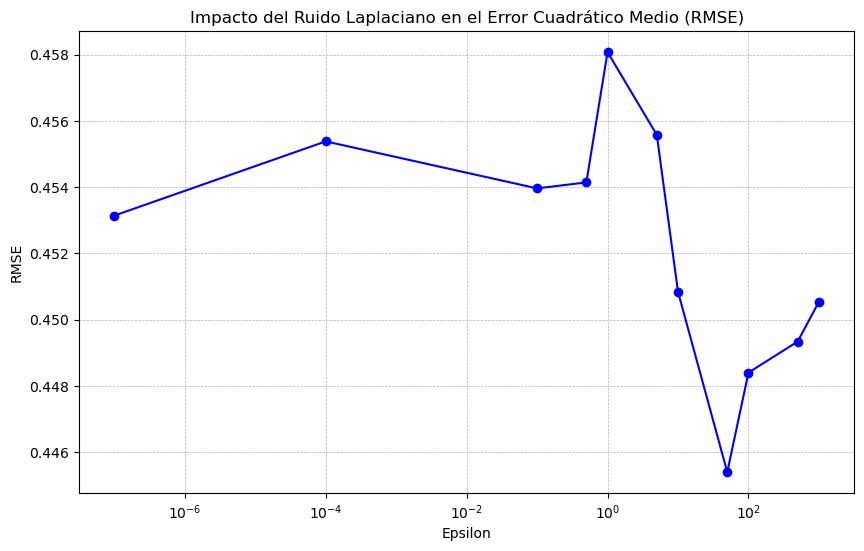

In [8]:
import numpy as np
import ModeloBase
from ModeloBase import read_data_model, add_laplace_noise, rmse
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


np.random.seed(42) 


all_data = fetch_california_housing()
X_train_val, X_val, X_test, Y_train_val, Y_val, Y_test = read_data_model(all_data, 'MedInc')

# Entrenamos el scanner con los datos train_val para evitar fuga de datos antes del entrenamiento
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(random_state=42)

# Definir los parámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [100, 200, 300],        # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],        # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],        # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de muestras necesarias en una hoja
    'max_features': [None, 'sqrt', 'log2'] # Número de características a considerar al buscar la mejor división
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train_val_scaled, Y_train_val)
best_params = grid_search.best_params_

# Imprimir los mejores parámetros encontrados
print("Best parameters found:", best_params)

# Initial model training without noise
model_original = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluate original model (without noise)
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
RMSE_original = rmse(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print("Predicción de precios de casas sin ruido:")
print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"RMSE: {RMSE_original}")
print(f"R2: {R2_original}")

# Diagrama de dispersión de valores predichos vs valores reales
plt.figure(figsize=(5, 5))
plt.scatter(Y_test, Y_predict, alpha=0.5, color='blue', label='Valores Predichos vs Reales')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Línea X=Y')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales RandomForest')
plt.legend()
plt.grid(True)

# Guardar la imagen
plt.savefig('diagrama_dispersion_RandomForest.png',  dpi=300)
plt.show()
# Iterate over different epsilon values
epsilon_values = [0.0000001, 0.0001, 0.1, 0.5, 1.0, 5 , 10, 50, 100, 500, 1000] 
results = []

for epsilon in epsilon_values:
    print(f"\nEpsilon = {epsilon}")

    # Step 1: Add Laplacian noise to the income column in the training set only
    X_train_val_noisy = add_laplace_noise(X_train_val, epsilon)

    MSE_original = mse(X_train_val, X_train_val_noisy)
    MAE_original = mae(X_train_val, X_train_val_noisy)
    RMSE_original = rmse(X_train_val, X_train_val_noisy)
    R2_original = r2(X_train_val, X_train_val_noisy)

    print("Error del ruido:")
    print(f"MSE: {MSE_original}")
    print(f"MAE: {MAE_original}")
    print(f"RMSE: {RMSE_original}")
    print(f"R2: {R2_original}")

    # Step 2: Train the model using noisy income values for training
    scaler = StandardScaler()
    X_train_val_noisy_scaled = scaler.fit_transform(X_train_val_noisy)
    X_test_scaled = scaler.transform(X_test)

    model_noisy = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42)
    model_noisy.fit(X_train_val_noisy_scaled, Y_train_val)
    Y_predict = model_noisy.predict(X_test_scaled)

    # Step 3: Evaluate the model trained with noisy data using the original validation set
    MSE_noisy = mse(Y_test, Y_predict)
    MAE_noisy = mae(Y_test, Y_predict)
    RMSE_noisy = rmse(Y_test, Y_predict)
    R2_noisy = r2(Y_test, Y_predict)

    print("\nPredicción de precios con ruido:")
    print(f"MSE: {MSE_noisy}")
    print(f"MAE: {MAE_noisy}")
    print(f"RMSE: {RMSE_noisy}")
    print(f"R2: {R2_noisy}")

    results.append((epsilon,MSE_noisy ,MAE_noisy, RMSE_noisy, R2_noisy))

# Display the results
import pandas as pd
results_df = pd.DataFrame(results, columns=["Epsilon", "MSE", "MAE", "RMSE", "R2"])
print(results_df)


# Graficar el RMSE en función del valor de epsilon
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epsilon"], results_df["RMSE"], marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Usar escala logarítmica para epsilon
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('Impacto del Ruido Laplaciano en el Error Cuadrático Medio (RMSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('RandomForest_rmse_vs_epsilon.png', dpi=300)
plt.show()
